In [59]:
from __future__ import print_function

In [60]:

import numpy as np
import scipy
import matplotlib.pyplot as plt

import sklearn.cluster

import librosa
import librosa.display

In [61]:
y, sr = librosa.load('/Users/admin/Downloads/song.mp3')

In [62]:
BINS_PER_OCTAVE = 12 * 3
N_OCTAVES = 7
C = librosa.amplitude_to_db(librosa.cqt(y=y, sr=sr,
                                        bins_per_octave=BINS_PER_OCTAVE,
                                        n_bins=N_OCTAVES * BINS_PER_OCTAVE),
                            ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(C, y_axis='cqt_hz', sr=sr,
                         bins_per_octave=BINS_PER_OCTAVE,
                         x_axis='time')
plt.tight_layout()

In [63]:
C.shape


(252, 20526)

In [64]:
y.shape

(10509120,)

In [65]:
tempo, beats = librosa.beat.beat_track(y=y, sr=sr, trim=False)
Csync = librosa.util.sync(C, beats, aggregate=np.median)

# For plotting purposes, we'll need the timing of the beats
# we fix_frames to include non-beat frames 0 and C.shape[1] (final frame)
beat_times = librosa.frames_to_time(librosa.util.fix_frames(beats,
                                                            x_min=0,
                                                            x_max=C.shape[1]),
                                    sr=sr)

plt.figure(figsize=(12, 4))
librosa.display.specshow(Csync, bins_per_octave=12*3,
                         y_axis='cqt_hz', x_axis='time',
                         x_coords=beat_times)
plt.tight_layout()

In [66]:
R = librosa.segment.recurrence_matrix(Csync, width=3, mode='affinity',
                                      sym=True)

# Enhance diagonals with a median filter (Equation 2)
df = librosa.segment.timelag_filter(scipy.ndimage.median_filter)
Rf = df(R, size=(1, 7))


In [67]:
Rf.shape

(1183, 1183)

In [68]:
mfcc = librosa.feature.mfcc(y=y, sr=sr)
Msync = librosa.util.sync(mfcc, beats)

path_distance = np.sum(np.diff(Msync, axis=1)**2, axis=0)
sigma = np.median(path_distance)
path_sim = np.exp(-path_distance / sigma)

R_path = np.diag(path_sim, k=1) + np.diag(path_sim, k=-1)

In [69]:
mfcc.shape

(20, 20526)

In [70]:
deg_path = np.sum(R_path, axis=1)
deg_rec = np.sum(Rf, axis=1)

mu = deg_path.dot(deg_path + deg_rec) / np.sum((deg_path + deg_rec)**2)

A = mu * Rf + (1 - mu) * R_path

In [71]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
librosa.display.specshow(Rf, cmap='inferno_r', y_axis='time',
                         y_coords=beat_times)
plt.title('Recurrence similarity')
plt.subplot(1, 3, 2)
librosa.display.specshow(R_path, cmap='inferno_r')
plt.title('Path similarity')
plt.subplot(1, 3, 3)
librosa.display.specshow(A, cmap='inferno_r')
plt.title('Combined graph')
plt.tight_layout()

In [72]:
L = scipy.sparse.csgraph.laplacian(A, normed=True)


# and its spectral decomposition
evals, evecs = scipy.linalg.eigh(L)


# We can clean this up further with a median filter.
# This can help smooth over small discontinuities
evecs = scipy.ndimage.median_filter(evecs, size=(9, 1))


# cumulative normalization is needed for symmetric normalize laplacian eigenvectors
Cnorm = np.cumsum(evecs**2, axis=1)**0.5

# If we want k clusters, use the first k normalized eigenvectors.
# Fun exercise: see how the segmentation changes as you vary k

k = 5

X = evecs[:, :k] / Cnorm[:, k-1:k]


# Plot the resulting representation (Figure 1, center and right)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 2)
librosa.display.specshow(Rf, cmap='inferno_r')
plt.title('Recurrence matrix')

plt.subplot(1, 2, 1)
librosa.display.specshow(X,
                         y_axis='time',
                         y_coords=beat_times)
plt.title('Structure components')
plt.tight_layout()

In [73]:
KM = sklearn.cluster.KMeans(n_clusters=k)

seg_ids = KM.fit_predict(X)


# and plot the results
plt.figure(figsize=(12, 4))
colors = plt.get_cmap('Paired', k)

plt.subplot(1, 3, 2)
librosa.display.specshow(Rf, cmap='inferno_r')
plt.title('Recurrence matrix')
plt.subplot(1, 3, 1)
librosa.display.specshow(X,
                         y_axis='time',
                         y_coords=beat_times)
plt.title('Structure components')
plt.subplot(1, 3, 3)
librosa.display.specshow(np.atleast_2d(seg_ids).T, cmap=colors)
plt.title('Estimated segments')
plt.colorbar(ticks=range(k))
plt.tight_layout()

In [74]:
bound_beats = 1 + np.flatnonzero(seg_ids[:-1] != seg_ids[1:])

# Count beat 0 as a boundary
bound_beats = librosa.util.fix_frames(bound_beats, x_min=0)

# Compute the segment label for each boundary
bound_segs = list(seg_ids[bound_beats])

# Convert beat indices to frames
bound_frames = beats[bound_beats]

# Make sure we cover to the end of the track
bound_frames = librosa.util.fix_frames(bound_frames,
                                       x_min=None,
                                       x_max=C.shape[1]-1)

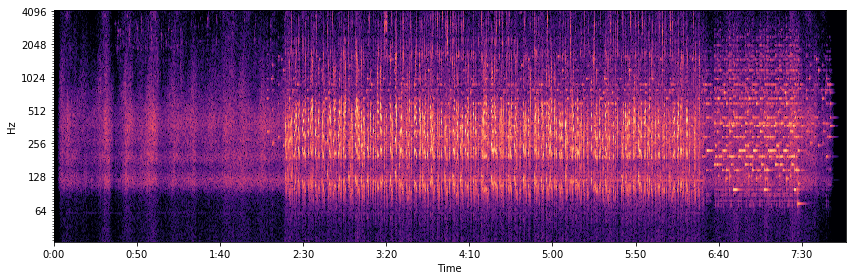

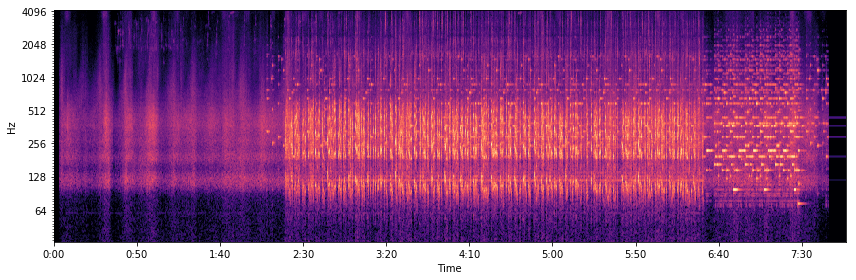

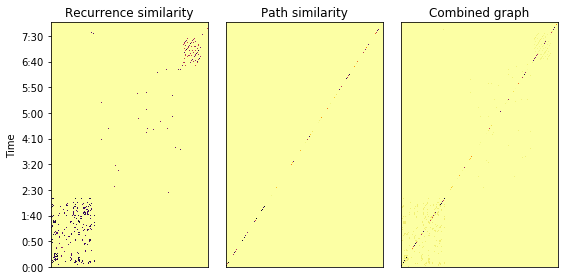

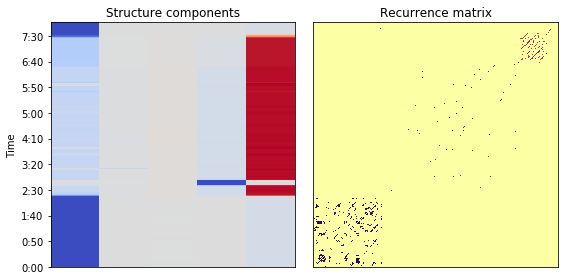

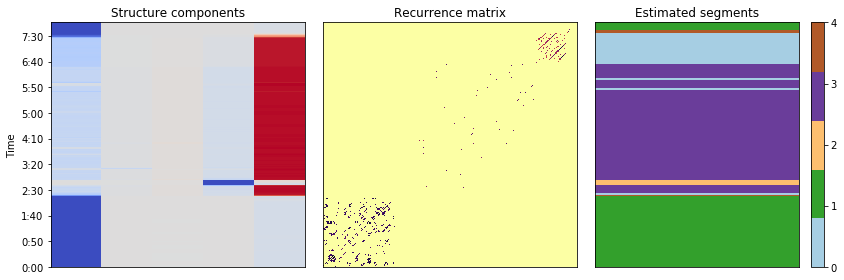

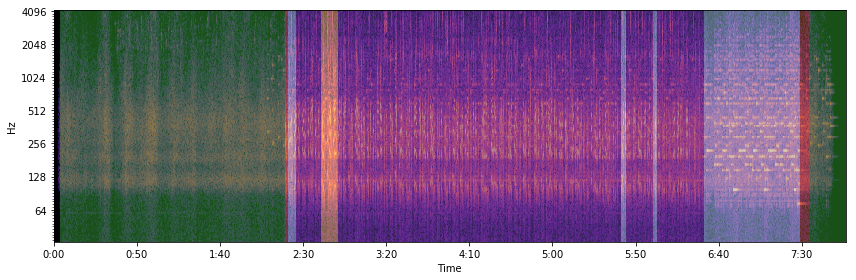

In [75]:
import matplotlib.patches as patches
plt.figure(figsize=(12, 4))

bound_times = librosa.frames_to_time(bound_frames)
freqs = librosa.cqt_frequencies(n_bins=C.shape[0],
                                fmin=librosa.note_to_hz('C1'),
                                bins_per_octave=BINS_PER_OCTAVE)

librosa.display.specshow(C, y_axis='cqt_hz', sr=sr,
                         bins_per_octave=BINS_PER_OCTAVE,
                         x_axis='time')
ax = plt.gca()

for interval, label in zip(zip(bound_times, bound_times[1:]), bound_segs):
    ax.add_patch(patches.Rectangle((interval[0], freqs[0]),
                                   interval[1] - interval[0],
                                   freqs[-1],
                                   facecolor=colors(label),
                                   alpha=0.50))

plt.tight_layout()
plt.show()

In [76]:
bound_times.shape

(18,)

In [79]:
X

array([[ -9.97067203e-01,   9.06943020e-04,  -1.38624262e-03,
          5.69841296e-03,  -7.63005692e-02],
       [ -9.97067203e-01,   9.06943020e-04,  -1.38624262e-03,
          5.69841296e-03,  -7.63005692e-02],
       [ -9.97067203e-01,   9.06943020e-04,  -1.38624262e-03,
          5.69841296e-03,  -7.63005692e-02],
       ..., 
       [ -9.99179362e-01,   7.10541756e-04,  -1.07500895e-03,
          4.33976065e-03,  -4.02505813e-02],
       [ -9.99179362e-01,   7.10541756e-04,  -1.07500895e-03,
          4.33976065e-03,  -4.02505813e-02],
       [ -9.99172993e-01,   7.12855434e-04,  -1.07856930e-03,
          4.35431374e-03,  -4.04066755e-02]])

In [80]:
X

(1183, 5)

In [81]:
seg_ids

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [82]:
seg_ids.shape

(1183,)

In [83]:
xx={}
for i in seg_ids:
    if i not in xx:
        xx[i] =  1 
    else:
        xx[i] = xx[i] + 1 
print(xx)
        

{1: 380, 4: 15, 0: 174, 3: 589, 2: 25}


In [84]:
beat_times

array([   0.        ,    3.78485261,    4.17959184, ...,  466.39600907,
        466.76752834,  476.61278912])

In [85]:
beat_times.shape

(1184,)

In [108]:
pre_id = seg_ids[0]
st = beat_times[0]
ed=''

for i in range(0,len(beat_times)-1):
    id = seg_ids[i]
    if id != pre_id:
        ed = beat_times[i]
        print(seg_ids[i-1], st, ed)
        st = ed
    else:
        st = beat_times[i-1]
    pre_id = id
print(seg_ids[i],st, beat_times[i+1])



1 138.76244898 139.575147392
4 139.575147392 140.387845805
0 142.01324263 142.872380952
3 142.872380952 143.243900227
0 143.615419501 144.428117914
3 144.428117914 144.869297052
0 144.869297052 145.31047619
3 159.915827664 160.658866213
2 169.552108844 170.364807256
3 340.195555556 341.008253968
0 342.889070295 343.632108844
3 359.282358277 360.025396825
0 361.488253968 362.208072562
3 389.746938776 390.513197279
0 447.750385488 448.539863946
4 452.90521542 453.694693878
1 466.39600907 476.612789116
